# Monzo Data Analysis Jan 20th 2018 - Nov 26th 2019

## Import and clean the data

In [1]:
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
from datetime import datetime
import scipy
import numpy as np
import seaborn as sns

In [2]:
#import the json
data = pd.read_json('/Users/danielharrison/PycharmProjects/HelloWorld/transactions.json')

In [3]:
#flatten the json 
trans = json_normalize(data['transactions'], sep="_")

In [4]:
print(trans.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Columns: 142 entries, account_balance to user_id
dtypes: bool(8), float64(6), int64(3), object(125)
memory usage: 4.9+ MB
None


In [5]:
#convert the 'created' series into a datettime series
trans['created'] = pd.to_datetime(trans['created'],utc=True, format='%Y-%m-%d')

In [6]:
#not interested in times, so have set the time value to be midnight for each row
trans['date'] = trans['created'].dt.floor('d')

In [7]:
#set the index of the entire dataframe to be 'date'
trans = trans.set_index(trans['date'])

In [8]:
#create two columns for date and month
trans['year'] = pd.DatetimeIndex(trans['date']).year
trans['month'] = pd.DatetimeIndex(trans['date']).month

In [9]:
#convert the amount column into pounds and force positive values to be purchases i.e. amounts leaving the account
trans['amount'] = trans['amount'].apply(lambda x: -1 * (x/100))

In [10]:
#only incude transactions which correspond to spending i.e. don't include internal pot transfers
trans = trans[trans['include_in_spending'] == True]

# EDA transaction amounts

In [11]:
trans_pos_amount = trans[trans['amount'] > 0]

In [12]:
df6 = trans_pos_amount.amount

[]

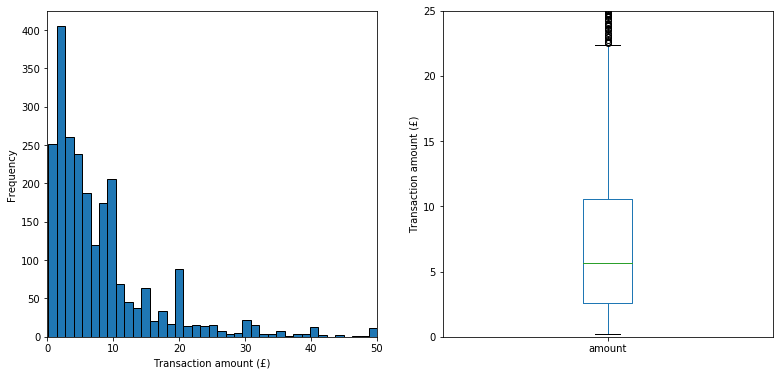

In [13]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,6))

df6.plot(kind='hist', bins=600, grid=False, edgecolor = 'black', ax=ax1)
ax1.set_xlim(0,50)
ax1.set_xlabel('Transaction amount (£)')
df6.plot(kind='box', ax=ax2)
ax2.set_ylim(0,25)
ax2.set_ylabel('Transaction amount (£)')
plt.plot()


In [14]:
trans_pos_amount.loc['2018'].amount.describe()

count    815.000000
mean      15.650147
std       41.771082
min        0.450000
25%        2.990000
50%        6.000000
75%       14.475000
max      550.000000
Name: amount, dtype: float64

In [15]:
trans_pos_amount.loc['2019'].amount.describe()

count    1649.000000
mean       13.940309
std        45.796905
min         0.180000
25%         2.600000
50%         5.600000
75%        10.100000
max       768.000000
Name: amount, dtype: float64

In [16]:
trans_pos_amount.amount.describe()

count    2464.000000
mean       14.505860
std        44.504418
min         0.180000
25%         2.600000
50%         5.660000
75%        10.550000
max       768.000000
Name: amount, dtype: float64

# EDA spend categories & merchants

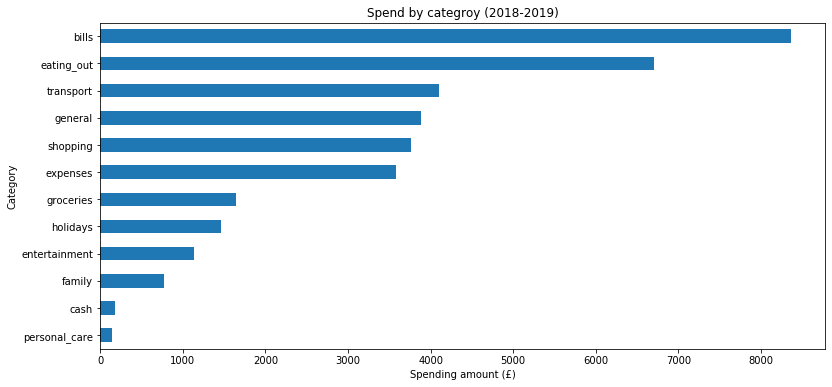

In [17]:
trans_pos_amount.groupby('category').amount.sum().sort_values().plot(kind='barh',figsize=(13,6))
plt.ylabel('Category')
plt.xlabel('Spending amount (£)')
plt.title('Spend by categroy (2018-2019)')
plt.show()


In [18]:
merch_freq = trans['merchant_name'].value_counts()

In [19]:
merch_amount = trans.groupby(trans['merchant_name'], sort=True).sum().sort_values('amount', ascending=False)

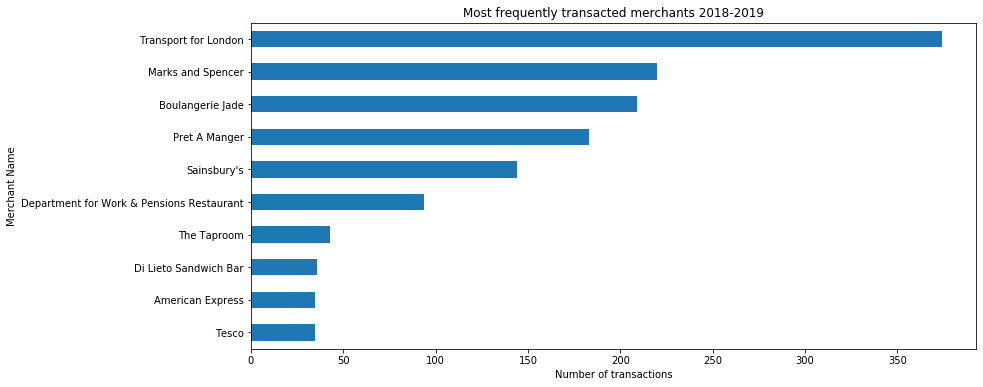

In [21]:
merch_freq.nlargest(10).sort_values().plot(kind='barh', figsize=(13,6))
plt.xlabel('Number of transactions')
plt.ylabel('Merchant Name')
plt.title('Most frequently transacted merchants 2018-2019')
plt.show()

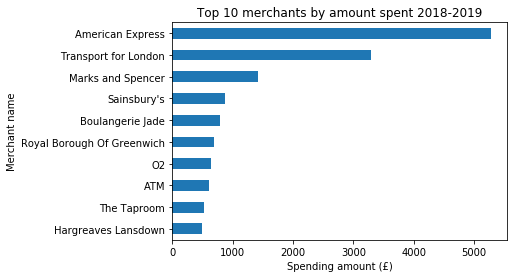

In [22]:
merch_amount['amount'].nlargest(10).sort_values().plot(kind='barh')
plt.xlabel('Spending amount (£)')
plt.ylabel('Merchant name')
plt.title('Top 10 merchants by amount spent 2018-2019')
plt.show()

In [23]:
merch_amount = trans.groupby(trans['merchant_name'], sort=True).sum().sort_values('amount', ascending=False)

In [24]:
merch_list = merch_freq.index.values.tolist()

In [26]:
def get_amount(merch_name):
    return [merch_name, trans[trans['merchant_name'] == merch_name].amount.sum()]

In [28]:
x_list = []
for merch in merch_list:
    x = get_amount(merch)
    x_list.append(x)
    

In [30]:
df_merch = pd.DataFrame(x_list)

In [31]:
df_merch.columns = ['Merchant', 'Total amount spent (£)']

In [32]:
df_merch.head()

Merchant  Total amount spent (£)
0  Transport for London                 3299.20
1     Marks and Spencer                 1421.64
2      Boulangerie Jade                  798.85
3         Pret A Manger                  238.47
4           Sainsbury's                  878.05

In [33]:
df_merch.insert(1, 'Number of transactions', list(merch_freq))

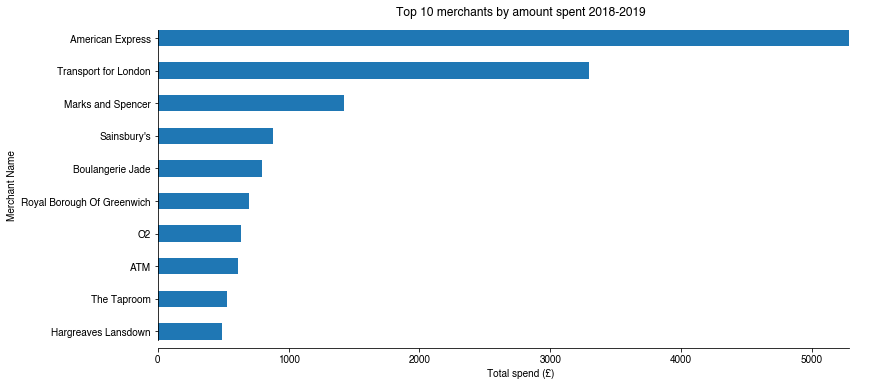

In [34]:
fig, ax = plt.subplots(figsize=(13,6))
df_merch.nlargest(10, 'Total amount spent (£)').sort_values('Total amount spent (£)', ascending=True).plot(kind='barh', x='Merchant', y='Total amount spent (£)', legend = False, ax=ax)
ax.set_xlabel('Total spend (£)')
ax.set_ylabel('Merchant Name')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_smart_bounds(True)
ax.spines['bottom'].set_smart_bounds(True)
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.title('Top 10 merchants by amount spent 2018-2019')
plt.show()


## EDA : Exploring 2018 spending trends by month

In [36]:
#filter on transactions within 2018 only
df_2018 = trans_pos_amount.loc['2018']

In [37]:
#down sample the data by daily frequency and calculate the 'sum' of row entry column's
df_2018_daily_resample = df_2018.resample('D').sum()

In [38]:
#down sample the data by monthly frequency and calculate the 'sum' of row entry column's
df_2018_monthly_resample = df_2018.resample('M').sum()

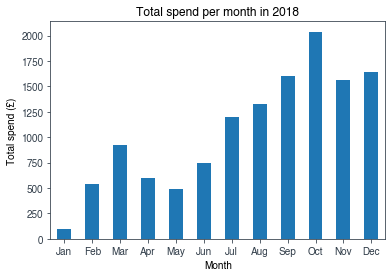

In [40]:
labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_2018_monthly_resample.amount.plot(kind='bar')
plt.title('Total spend per month in 2018')
plt.ylabel('Total spend (£)')
plt.xlabel('Month')
plt.xticks(range(12), labels, rotation=0)
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

## EDA : Exploring 2019 spending trends by month

In [41]:
#filter on transactions within 2019 only
df_2019 = trans_pos_amount.loc['2019']

In [42]:
#down sample the data by daily frequency and calculate the 'sum' of row entry column's
df_2019_daily_resample = df_2019.resample('D').sum()

In [43]:
#down sample the data by monthly frequency and calculate the 'sum' of row entry column's
df_2019_monthly_resample = df_2019.resample('M').sum()

In [44]:
labels_2018 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
labels_2019 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']

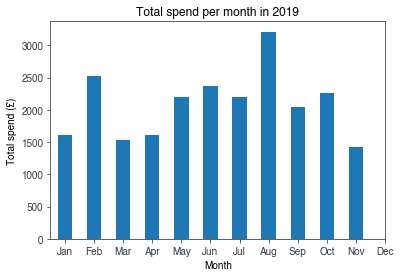

In [45]:
labels_2019 = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov']
df_2019_monthly_resample.amount.plot(kind='bar')
plt.title('Total spend per month in 2019')
plt.ylabel('Total spend (£)')
plt.xlabel('Month')
plt.xticks(range(12), labels, rotation=0)
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.show()

## Combining and comparing 2019 & 2018 spending data

In [46]:
df_2019_new_index = df_2019_monthly_resample.set_index([labels_2019])

In [47]:
df_2018_new_index = df_2018_monthly_resample.set_index([labels_2018])

In [48]:
df_2018_vs_2019 = pd.DataFrame({'2018':df_2018_new_index.amount, '2019':df_2019_new_index.amount}, index=labels_2018)

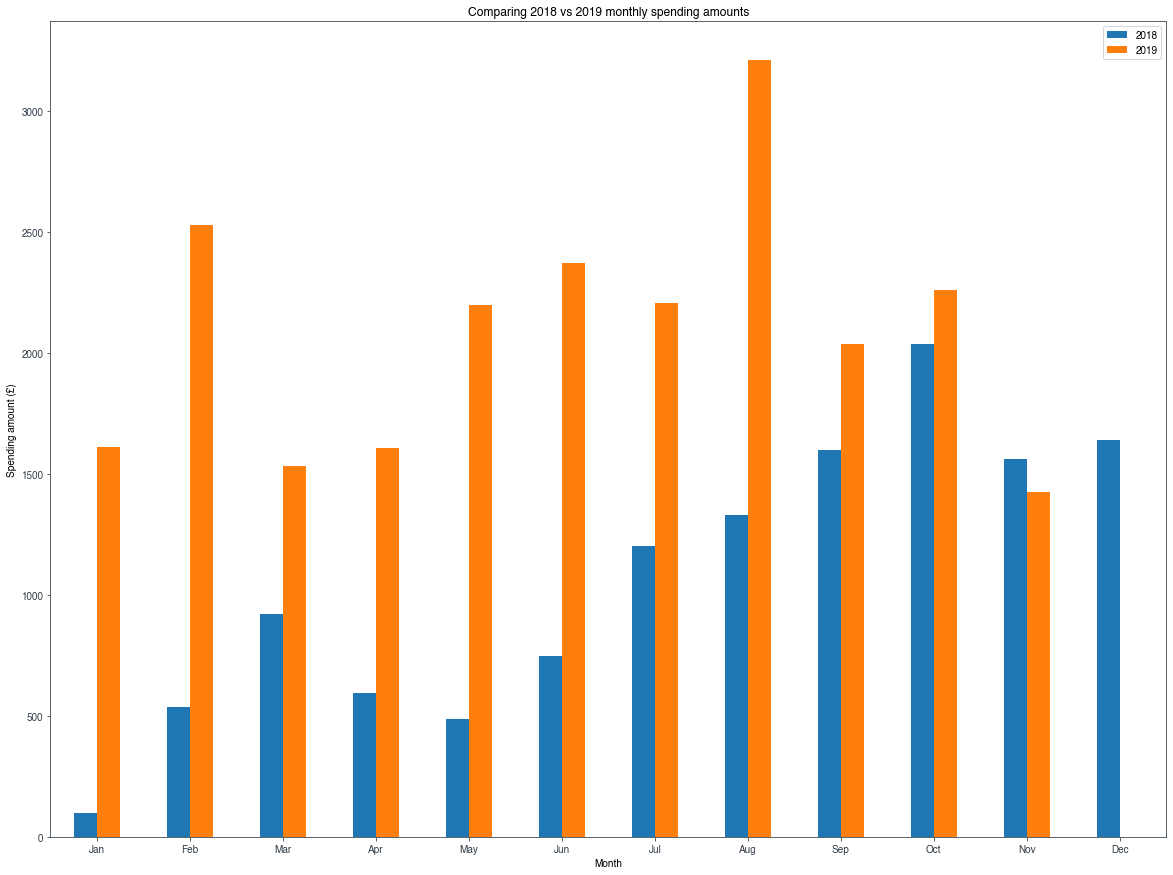

In [49]:
df_2018_vs_2019.plot(kind='bar', figsize=(20,15))
plt.title('Comparing 2018 vs 2019 monthly spending amounts')
plt.xlabel('Month')
plt.ylabel('Spending amount (£)')
plt.rcParams["axes.grid"] = False
plt.rcParams['axes.facecolor'] = 'white'
plt.xticks(rotation=0)
plt.show()

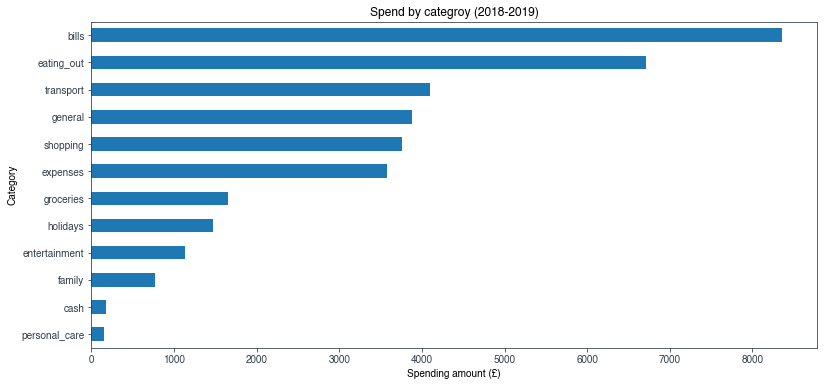

In [50]:
trans_pos_amount.groupby('category').amount.sum().sort_values().plot(kind='barh',figsize=(13,6))
plt.ylabel('Category')
plt.xlabel('Spending amount (£)')
plt.title('Spend by categroy (2018-2019)')
plt.show()
